# Name to Language Classification using RNNs


## Load required libs, name-to-language data and util funcs

In [1]:
import os
import glob
import time
import math
import string
import random
import unicodedata
from io import open as io_open

import torch
import torch.nn as nn


ALL_LETTERS = string.ascii_letters + " .,;'" # character to consider
n_letters = len(ALL_LETTERS)                 # length of one hot char encodiing vector


def unicode_to_ascii(string):
    """convert unicode string to plain ascii, removing any accents"""
    return ''.join(c for c in unicodedata.normalize('NFD', string)
                  if unicodedata.category(c) != 'Mn' and 
                   c in ALL_LETTERS)


def file_list(path):
    return glob.glob(path)


def read_lines_in_file(filename):
    """get list of lines from file
    """
    lines = io_open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

## Load name-to-category/language data

In [2]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []
data_glob = "../data/names/*.txt"

# populate the categories
for class_file_path in file_list(data_glob):
    category_name = os.path.basename(class_file_path).split('.')[0] # language name
    all_categories.append(category_name)
    category_lines[category_name] = read_lines_in_file(class_file_path)
    
n_categories = len(all_categories)

## Convert names into one-hot-encoded tensors

one letter shape `<1 x n_letters>`

one word shape `<word_length x 1 x n_letters>`

In [3]:
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)


def letter_to_tensor(letter):
    letter_idx = letter_to_index(letter)
    letter_tensor = torch.zeros((1, n_letters), dtype=torch.uint8)
    letter_tensor[0][letter_idx] = 1
    return letter_tensor


def line_to_tensor(line):
    line_tensor = torch.zeros((len(line), 1, n_letters), dtype=torch.uint8)
    for i,char in enumerate(line):
        vec_i = letter_to_index(char)
        line_tensor[i][0][vec_i] = 1
    return line_tensor

In [4]:
letter_to_tensor('a').shape, line_to_tensor('abc').shape

(torch.Size([1, 57]), torch.Size([3, 1, 57]))

## Create the RNN architecture

In [13]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.in2out = nn.Linear(input_size + hidden_size, output_size)
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, x, h):
        x_h = torch.cat((x, h), 1)
        hidden = self.in2hidden(x_h)
#         hidden = self.tanh(hidden)
        out = self.in2out(x_h)
        out = self.logsoftmax(out)
        return out, hidden
    
    def init_hidden(self):
        return torch.zeros([1, self.hidden_size])

In [14]:
# testing our simple RNN 
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

cinput = letter_to_tensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(cinput, hidden)
print(cinput.shape, output.shape, next_hidden.shape)

torch.Size([1, 57]) torch.Size([1, 18]) torch.Size([1, 128])


In [15]:
# structure of our simple RNN
rnn

RNN(
  (in2out): Linear(in_features=185, out_features=18, bias=True)
  (in2hidden): Linear(in_features=185, out_features=128, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
  (tanh): Tanh()
)

## Training

In [16]:
def get_category_from_output(output):
    category_i = torch.argmax(output)
    return all_categories[category_i], category_i.item()

def get_random_training_example():
    category = random.choice(all_categories)
    category_line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(category_line)
    return category, category_line, category_tensor, line_tensor

In [17]:
for i in range(10):
    category, line, category_tensor, line_tensor = get_random_training_example()
    print('category =', category, '/ line =', line)

category = French / line = Deforest
category = Polish / line = Smolak
category = Portuguese / line = Campos
category = Arabic / line = Zogby
category = Spanish / line = Porra
category = Chinese / line = Lu
category = Scottish / line = Murray
category = Czech / line = Bastl
category = Russian / line = Jakimenko
category = Polish / line = Dziedzic


Each loop of training will:

-   Create input and target tensors
-   Create a zeroed initial hidden state
-   Read each letter in and
    -   Keep hidden state for next letter
-   Compare final output to target
-   Back-propagate
-   Return the output and loss

In [18]:
# loss criterion
criterion = nn.NLLLoss()

# learning rate
lr = 0.0056

# number of iterations
iterations = 100000

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [19]:
def train_one_iter(category_tensor, line_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    
    # pass each char in line thorugh RNN
    for ctensor in line_tensor:
        output, hidden = rnn(ctensor, hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    # Add parameters' gradients to their values, multiplied by learning rate
    # this is done by an optimizer usually
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lr)

    return output, loss.item()


def get_time_since(start):
    now = time.time()
    s = now - start
    m = s / 60
    s = m - int(m)
    return f"{int(m)}m:{int(s*60)}s"

## training loop

In [20]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
start_time = time.time()
current_loss = 0
all_losses = []

for i in range(1, n_iters+1):
    category, category_line, category_tensor, line_tensor = get_random_training_example()
    pred_category_tensor, loss = train_one_iter(category_tensor, line_tensor)
    
    current_loss += loss
    if i % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0

    if i % print_every == 0:
        pred_category, cat_idx = get_category_from_output(pred_category_tensor)
        correct = '✓' if pred_category == category else f"✗ ({category})"
        print(f"Iteration: {i} {i*100/(n_iters)}% Loss:{loss:.4f} {get_time_since(start_time)} {category_line} {pred_category} {correct}")

Iteration: 5000 5.0% Loss:2.1207 0m:3s Morinaga Japanese ✓
Iteration: 10000 10.0% Loss:2.6438 0m:7s Blake Japanese ✗ (English)
Iteration: 15000 15.0% Loss:1.3013 0m:11s Chweh Vietnamese ✗ (Korean)
Iteration: 20000 20.0% Loss:2.9391 0m:15s Bahlulzade Irish ✗ (Russian)
Iteration: 25000 25.0% Loss:2.6675 0m:19s Zee Chinese ✗ (Dutch)
Iteration: 30000 30.0% Loss:0.6597 0m:23s Sin Korean ✓
Iteration: 35000 35.0% Loss:2.1416 0m:26s Young Chinese ✗ (Scottish)
Iteration: 40000 40.0% Loss:1.2387 0m:30s Entwistle English ✓
Iteration: 45000 45.0% Loss:1.0667 0m:34s Etxeberria Spanish ✓
Iteration: 50000 50.0% Loss:0.9754 0m:38s Sauveterre French ✓
Iteration: 55000 55.0% Loss:0.2157 0m:42s Nguyen Vietnamese ✓
Iteration: 60000 60.0% Loss:0.3954 0m:46s Stavropoulos Greek ✓
Iteration: 65000 65.0% Loss:0.5425 0m:50s Jelinek Czech ✓
Iteration: 70000 70.0% Loss:0.2175 0m:54s Totolos Greek ✓
Iteration: 75000 75.0% Loss:0.4079 0m:58s Tosetti Italian ✓
Iteration: 80000 80.0% Loss:0.8244 1m:3s Snaaijer Dutch 

## Plotting the results

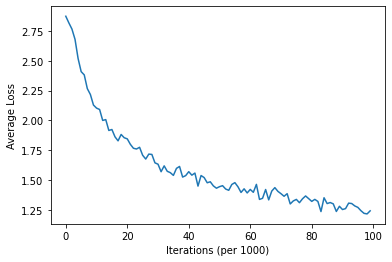

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.xlabel(f"Iterations (per {plot_every})")
plt.ylabel(f"Average Loss")
plt.plot(all_losses)

## Evaluating results

/Users/samridha.shrestha/Main/projects/ml_recurrent_neural_network/venv/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/samridha.shrestha/Main/projects/ml_recurrent_neural_network/venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


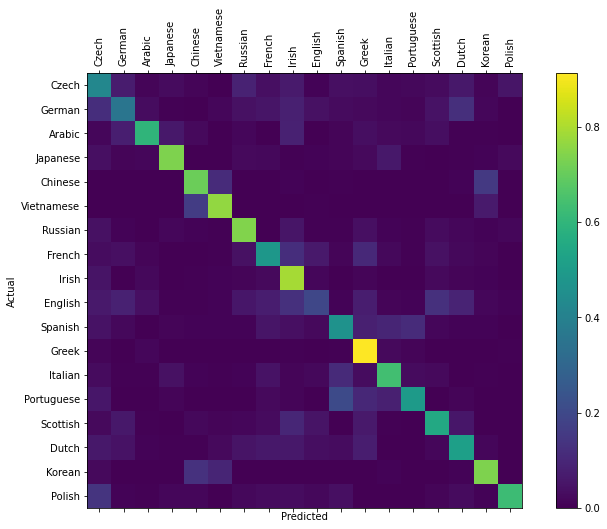

In [26]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# return an output tensor of size n_categories given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = get_random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = get_category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Set axes labels
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [27]:
# evaluate on the whole dataset
correct, total = 0, 0
for cat_idx, category in enumerate(all_categories):
    for line in category_lines[category]:
        line_tensor = line_to_tensor(line)
        output = evaluate(line_tensor)
        _, guess_i = get_category_from_output(output)
        correct += 1 if guess_i == cat_idx else 0
        total += 1
        
print(f"Accuracy: {100*correct/total:.2f}%")

Accuracy: 58.36%


## Inference on user input

In [24]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.31) Russian
(-1.53) Czech
(-4.29) Irish

> Jackson
(-0.22) Scottish
(-2.56) English
(-2.68) Russian

> Satoshi
(-0.90) Italian
(-1.58) Japanese
(-2.50) Polish
